In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time
import ast

In [22]:
galaxy = np.loadtxt('phase12k.txt')
pos = galaxy[:,0:2]
vel = galaxy[:,3:5]
mass = galaxy[:10,6:7]

In [23]:
class Division:
    def __init__(self, center, height, width, bodies,allBoxes):
        self.center = center
        self.bodies = bodies
        self.height = height
        self.width = width
        self.multipliers = {"topleft": [-1, 1], "topright": [1, 1], "bottomleft": [-1, -1], "bottomright": [1, -1]}
        self.subdivisions = {"topleft":np.empty((0,2)), "topright": np.empty((0,2)), "bottomleft": np.empty((0,2)), "bottomright": np.empty((0,2))}
        self.newCenters = {"topleft": None, "topright": None, "bottomleft": None, "bottomright": None}
        self.newHeights = {"topleft": None, "topright": None, "bottomleft": None, "bottomright": None}
        self.terminalNode = {"topleft": True, "topright": True, "bottomleft": True, "bottomright": True}
        self.quads = ['topleft','topright','bottomleft','bottomright']
    def divideFour(self):
        for i in range(len(self.bodies)):
            pos = self.bodies[i] - self.center 
            pos = pos.reshape(1,2)
            body = self.bodies[i].reshape(1,2)
            if pos[0,1] > 0:
                if pos[0,0] > 0:
                    self.subdivisions["topright"] = np.append(self.subdivisions["topright"], np.array(body), axis = 0)
                else:
                    self.subdivisions["topleft"]= np.append(self.subdivisions["topleft"], np.array(body), axis = 0)
            else:
                if pos[0,0] > 0:
                    self.subdivisions["bottomright"]= np.append(self.subdivisions["bottomright"], np.array(body), axis = 0)
                else:
                    self.subdivisions["bottomleft"]= np.append(self.subdivisions["bottomleft"], np.array(body), axis = 0)
    
    def nextCenters(self):
        for quadrant in self.quads:
            newYcenter = (self.height / 4) * self.multipliers[quadrant][1] + self.center[1]
            newXcenter = (self.width / 4) * self.multipliers[quadrant][0] + self.center[0]
            self.newCenters[quadrant] = [newXcenter, newYcenter]
            self.newHeights[quadrant] = self.height / 2  
            
    def inquireLists(self):
        self.terminalCount = 0
        for quadrant in self.quads:
#             print(self.subdivisions[quadrant])
            if len(self.subdivisions[quadrant]) == 0:
                self.terminalNode[quadrant] = True
                self.terminalCount+=1
#                 print('blank group')
            elif len(self.subdivisions[quadrant]) == 1:
                allBoxes[str(self.newCenters[quadrant])] = {'bodies':self.subdivisions[quadrant],'height':self.newHeights[quadrant],'com':calcCOM(self.subdivisions[quadrant])}#add center of mass, total mass, etc. here
                self.terminalNode[quadrant] = True
                self.terminalCount+=1
#                 print('size one group')
            else:
                self.terminalNode[quadrant] = False
    def outputMaxDepth(self):
        for quadrant in self.quads:
            if len(self.subdivisions[quadrant]) > 1:
                allBoxes[str(self.newCenters[quadrant])] = {'bodies':self.subdivisions[quadrant],'height':self.newHeights[quadrant],'com':calcCOM(self.subdivisions[quadrant])}#add center of mass, total mass, etc. here

In [24]:
def calcCOM(points):
    mass = 1 
    total_mass = len(points) * mass
    com = np.sum(points, axis=0)
    com = (1/total_mass) * com
    return com

In [32]:
t0=time.time()
def process_division_stack_with_depth(o, h, w, pos, allBoxes, max_depth):
    stack = [(o, h, w, pos, 0)]  # Initialize the stack with the initial division and depth
    
    while stack:
        center, height, width, bodies, depth = stack.pop()  # Pop a division from the stack
        div = Division(center, height, width, bodies, allBoxes)
        div.divideFour()
        div.nextCenters()
        div.inquireLists()

        if depth < max_depth:  # Check if maximum depth reached
            for quadrant, terminal in div.terminalNode.items():
                if not terminal:
                    new_center = div.newCenters[quadrant]
                    new_height = div.newHeights[quadrant]
                    new_bodies = div.subdivisions[quadrant]
                    stack.append((new_center, new_height, new_height, new_bodies, depth + 1))
        else:
            div.outputMaxDepth()
                    
# Usage
o = [0, 0]
allBoxes = {}
h = 200
w = 200
n_total = len(pos)
max_depth = 7 # Set the maximum depth limit
process_division_stack_with_depth(o, h, w, pos, allBoxes, max_depth)
t1=time.time()
print(t1-t0)

0.42072176933288574


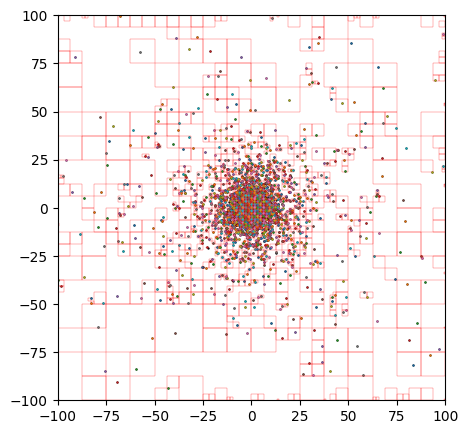

In [33]:
plt.figure(figsize=(5,5))

plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.scatter(pos[:, 0], pos[:, 1],s=0.5,color='k')

for center, data in allBoxes.items():
    center = ast.literal_eval(center)
    ybounds = [center[1] + data['height']/2, center[1] - data['height']/2]
    xbounds = [center[0] + data['height']/2, center[0] - data['height']/2]
    
    rect = plt.Rectangle((xbounds[1], ybounds[1]), data['height'], data['height'], edgecolor='r', facecolor='none',lw=.2)
    plt.gca().add_patch(rect)
    plt.scatter(data['com'][0],data['com'][1],s=.3)



plt.show()
